<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/twitch_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# font size

In [ ]:
def increase_font():
  from IPython.display import Javascript
  display(Javascript('''
  for (rule of document.styleSheets[0].cssRules){
    if (rule.selectorText=='body') {
      rule.style.fontSize = '24px'
      break
    }
  }
  '''))
get_ipython().events.register('pre_run_cell', increase_font)

# twitch sentiment

In [ ]:
!pip install openai
!pip install chat-downloader

<IPython.core.display.Javascript object>

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 12.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.1 MB/s eta 0:00:00


In [ ]:
import openai
import os
import matplotlib.pyplot as plt
from chat_downloader import ChatDownloader
import pandas as pd
from tqdm.notebook import tqdm
import time
import pickle

project_dir = "drive/My Drive/twitch-gpt-analyzer"
apikey = open('drive/My Drive/gptlulw/openaikey.txt')
openai.api_key = apikey.read()

<IPython.core.display.Javascript object>

In [ ]:
url = 'https://www.twitch.tv/videos/1785856844'
df_chat = pd.DataFrame()
downloader = ChatDownloader()
chat = downloader.get_chat(url=url)
vod = [msg for msg in chat]
vod = pd.DataFrame(vod)
vod['user'] = pd.json_normalize(vod['author'])['name']
vod['title'] = chat.title
vod['id'] = chat.id
df_chat = pd.concat([df_chat,vod], ignore_index=True)

df_chat['user_msg'] = df_chat['user'].add(': ').add(df_chat['message'])

<IPython.core.display.Javascript object>

In [ ]:
def update_chat_history(new_chat, chat_history):
  return chat_history+new_chat

def initialize_chat():
  chat_history = []
  sys_init = "You are a bot that specifically analyzes Twitch chat logs for natural language, psychological construct, and bot/fake user detection. Your replies are primarily numerical scores."
  new_chat = [{"role":"system", "content":sys_init}]
  chat_history = update_chat_history(new_chat, chat_history)
  return chat_history

def save_chat_history(chat_history, fn='chat_history.pkl'):
  with open(f"{project_dir}/{fn}", 'wb') as ch:
    pickle.dump(chat_history, ch)
  return None

def load_chat_history(fn):
  with open(fn, 'rb') as ch:
    chat_history = pickle.load(ch)
  return chat_history

<IPython.core.display.Javascript object>

In [ ]:
fn = f'{project_dir}/chat_history.pkl'
chat_history = load_chat_history(fn)

fn = f'{project_dir}/sentiment_history.pkl'
sentiment_history = load_chat_history(fn)
# chat_history = initialize_chat()

<IPython.core.display.Javascript object>

In [ ]:
bot = pd.Series()

max_tokens = 3000
model = 'gpt-4'

for idx,msg in tqdm(df_chat['user_msg'].iteritems(), total=df_chat.shape[0]):
  msg_input = f"""Is the following message from a bot and/or fake user?
    Answer only with a number:
      1 if the message is from a bot and/or fake user,
      0 if the message is not from a bot or fake user.
    The messages are formatted 'a: b' where a is the username
    and b is the message the user submits to the chat.

    Here is the message: {msg}"""
  new_chat = [{"role":"user", "content":msg_input}]
  chat_history = update_chat_history(new_chat, chat_history)
  try:
    response = openai.ChatCompletion.create(model=model, messages=new_chat, max_tokens=max_tokens)
  except:
    time.sleep(4)
    response = openai.ChatCompletion.create(model=model, messages=new_chat, max_tokens=max_tokens)
  reply = response['choices'][0]['message']['content']

  new_chat = [{"role":"assistant", "content":reply}]
  chat_history = update_chat_history(new_chat, chat_history)
  save_chat_history(chat_history)

  s = pd.Series([reply], index=[idx])
  bot = pd.concat([bot, s])

df_chat['is_bot'] = bot

<IPython.core.display.Javascript object>

<ipython-input-29-7d4588588b29>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  bot = pd.Series()
<ipython-input-29-7d4588588b29>:6: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx,msg in tqdm(df_chat['user_msg'].iteritems(), total=df_chat.shape[0]):


  0%|          | 0/577 [00:00<?, ?it/s]

In [ ]:
df_msgs = pd.DataFrame()
for idx in tqdm(range(len(chat_history))):
  try:
    msg = chat_history[idx]['content'].split('\n')[-1].split('    Here is the message: ')[-1]
    val = chat_history[idx+1]['content']
  except:
    continue

  if len(val)>1:
    continue
  _df = pd.DataFrame(index=[idx])
  _df['user_msg'] = msg
  _df['is_bot'] = val
  df_msgs = pd.concat([df_msgs, _df])
df_chat = df_chat.merge(df_msgs.drop_duplicates())
df_chat['is_bot'] = df_chat['is_bot'].astype(int)

<IPython.core.display.Javascript object>

  0%|          | 0/1155 [00:00<?, ?it/s]

In [ ]:
_df = df_chat.loc[:, ['user', 'is_bot']].groupby('user', as_index=False).mean()
_df['is_bot'] = _df['is_bot'].mul(100).round()
_df

<IPython.core.display.Javascript object>

,user,is_bot
0,ananonymousgifter,100.0
1,arrowbounce,0.0
2,b3ruc,0.0
3,bham21,22.0
4,bluepinstudio,0.0
5,data_dude,0.0
6,evanmmo,0.0
7,forcythe,0.0
8,ghettobob,0.0
9,gortv2,4.0


In [ ]:
sentiment_history = initialize_chat()
bot = pd.Series()

max_tokens = 3000
model = 'gpt-4'

for idx,msg in tqdm(df_chat['message'].iteritems(), total=df_chat.shape[0]):

  msg_input = f"""
    How negative or positive is this chat message on a 1-7 scale?
    Answer only with a number, with 1 being 'very negative' and 7 being 'very positive.'
    Here is the chat message:
    {msg}
    """
  new_chat = [{"role":"user", "content":msg_input}]
  sentiment_history = update_chat_history(new_chat, sentiment_history)
  try:
    response = openai.ChatCompletion.create(model=model, messages=new_chat, max_tokens=max_tokens)
  except:
    time.sleep(4)
    response = openai.ChatCompletion.create(model=model, messages=new_chat, max_tokens=max_tokens)
  reply = response['choices'][0]['message']['content']

  new_chat = [{"role":"assistant", "content":reply}]
  sentiment_history = update_chat_history(new_chat, sentiment_history)
  save_chat_history(sentiment_history, fn='sentiment_history.pkl')

  s = pd.Series([reply], index=[idx])
  bot = pd.concat([bot, s])

df_chat['sentiment'] = bot

<IPython.core.display.Javascript object>

<ipython-input-63-2df8cbaad145>:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx,msg in tqdm(df_chat['message'].iteritems(), total=df_chat.shape[0]):


  0%|          | 0/577 [00:00<?, ?it/s]

In [ ]:
df_msgs = pd.DataFrame()
for idx in tqdm(range(len(sentiment_history))):
  try:
    msg = sentiment_history[idx]['content'].split('\n')[-2].strip()
    val = sentiment_history[idx+1]['content']
  except:
    continue

  if len(val)>1:
    continue
  _df = pd.DataFrame(index=[idx])
  _df['message'] = msg
  _df['sentiment'] = val
  df_msgs = pd.concat([df_msgs, _df])
df_chat = df_chat.merge(df_msgs.drop_duplicates())

df_chat['sentiment_processed'] = df_chat['sentiment'].copy()
df_chat.loc[df_chat['sentiment_processed'].str.contains('cannot'), 'sentiment_processed'] = 4
df_chat['sentiment_processed'] = df_chat['sentiment_processed'].astype(float)

<IPython.core.display.Javascript object>

  0%|          | 0/1156 [00:00<?, ?it/s]

In [ ]:
df_msgs.loc[df_msgs['message']=='haha']

<IPython.core.display.Javascript object>

,message,sentiment
355,haha,7
357,haha,7
359,haha,5
361,haha,7


In [ ]:
_df =df_chat.loc[:, ['user', 'sentiment_processed']].groupby('user', as_index=False).mean()
_df.sort_values('sentiment_processed', ascending=False)

<IPython.core.display.Javascript object>

,user,sentiment_processed
0,arrowbounce,7.000000
10,hectorhsc,7.000000
14,lolsmellycheeses,6.500000
28,streamelements,6.250000
20,physbuzz,5.500000
18,nightbot,5.102190
29,trinipowerup,5.000000
24,rajonite,5.000000
16,memofortherecord,4.833333
25,rapidwhite,4.750000


In [ ]:
# emo_history = initialize_chat()
bot = pd.Series()

max_tokens = 3000
model = 'gpt-4'

for idx,msg in tqdm(df_chat['message'].iteritems(), total=df_chat.shape[0]):
  if idx<636:
    continue

  msg_input = f"""
    How much emotion is present in this chat message on a 1-7 scale?
    Answer only with a number, with 1 being 'no emotion' and 7 being 'a great deal of emotion.'
    Here is the chat message:
    {msg}
    """
  new_chat = [{"role":"user", "content":msg_input}]
  emo_history = update_chat_history(new_chat, emo_history)
  try:
    response = openai.ChatCompletion.create(model=model, messages=new_chat, max_tokens=max_tokens)
  except:
    time.sleep(4)
    response = openai.ChatCompletion.create(model=model, messages=new_chat, max_tokens=max_tokens)
  reply = response['choices'][0]['message']['content']

  new_chat = [{"role":"assistant", "content":reply}]
  emo_history = update_chat_history(new_chat, emo_history)
  save_chat_history(emo_history, fn='emo_history.pkl')

  s = pd.Series([reply], index=[idx])
  bot = pd.concat([bot, s])

df_chat['emo'] = bot
df_chat['emo'] = df_chat['emo'].astype(float)

<IPython.core.display.Javascript object>

In [ ]:
df_chat.head()

<IPython.core.display.Javascript object>

,message_id,author,time_in_seconds,timestamp,message,time_text,message_type,emotes,user,title,id,user_msg,is_bot,sentiment,sentiment_processed,emo
0,2dc84cb4-ed84-4d43-b0a6-e38c3a03cbe0,"{'id': '100135110', 'name': 'streamelements', ...",13,1680742687224000,nickwan_datasci is now live! Streaming Just Ch...,0:13,text_message,NaN,streamelements,Data science notebook reviews !comp,1785856844,streamelements: nickwan_datasci is now live! S...,0,5,5.0,3
1,fd9a19c5-b8b2-4fa4-a689-c3bde2a9d924,"{'id': '27061804', 'name': 'ghettobob', 'displ...",180,1680742853815000,YO,3:00,text_message,NaN,ghettobob,Data science notebook reviews !comp,1785856844,ghettobob: YO,0,4,4.0,3
2,7175fc29-8859-4c82-9664-6df8cd1dc3f3,"{'id': '19264788', 'name': 'nightbot', 'displa...",209,1680742883474000,How to use the new AI TTS: https://tts.monster...,3:29,text_message,NaN,nightbot,Data science notebook reviews !comp,1785856844,nightbot: How to use the new AI TTS: https://t...,1,6,6.0,2
3,7175fc29-8859-4c82-9664-6df8cd1dc3f3,"{'id': '19264788', 'name': 'nightbot', 'displa...",209,1680742883474000,How to use the new AI TTS: https://tts.monster...,3:29,text_message,NaN,nightbot,Data science notebook reviews !comp,1785856844,nightbot: How to use the new AI TTS: https://t...,1,5,5.0,3
4,504bc167-2d94-4925-a79b-90f8f044dc56,"{'id': '19264788', 'name': 'nightbot', 'displa...",914,1680743588269000,How to use the new AI TTS: https://tts.monster...,15:14,text_message,NaN,nightbot,Data science notebook reviews !comp,1785856844,nightbot: How to use the new AI TTS: https://t...,1,6,6.0,3


<IPython.core.display.Javascript object>

In [ ]:
_df =df_chat.loc[:, ['user', 'emo']].groupby('user', as_index=False).mean()
_df.sort_values('emo', ascending=False)

<IPython.core.display.Javascript object>

,user,emo
0,arrowbounce,5.500000
14,lolsmellycheeses,4.250000
29,trinipowerup,4.000000
28,streamelements,3.625000
21,purgatoires,3.545455
27,singlefatherof4kids,3.500000
13,lilyoungniz,3.500000
19,pacopaco,3.333333
26,rdrfan22,3.241935
5,evanmmo,3.153846


In [ ]:
import seaborn as sns

<IPython.core.display.Javascript object>

In [ ]:
df_plt = df_chat.loc[:, ['sentiment_processed','emo','is_bot']].groupby(['sentiment_processed','emo'], as_index=False).mean()
df_plt.shape

<IPython.core.display.Javascript object>

(36, 3)

In [ ]:
df_plt

<IPython.core.display.Javascript object>

,sentiment_processed,emo,is_bot
0,1.0,1.0,0.000000
1,1.0,3.0,0.333333
2,1.0,4.0,0.000000
3,2.0,1.0,0.000000
4,2.0,3.0,0.125000
5,2.0,4.0,0.500000
6,2.0,5.0,0.000000
7,3.0,1.0,0.461538
8,3.0,2.0,0.454545
9,3.0,3.0,0.298246


<IPython.core.display.Javascript object>

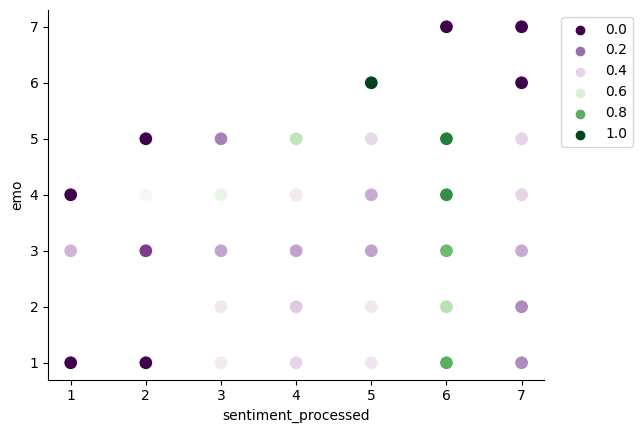

In [ ]:
sns.scatterplot(data=df_plt, x='sentiment_processed', y='emo', hue='is_bot', s=100, palette='PRGn')
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
sns.despine()
plt.show()